# Handling distractor interference in mixed and fixed search 
### A. A. Hanne, J. Tünnermann & A. Schubö

Fitting Bayesian Generalized Linear Mixed Models using the Python package Bambi.
Citation: Capretto, T., Piho, C., Kumar, R., Westfall, J., Yarkoni, T., & Martin, O. A. (2022). Bambi: A Simple Interface for Fitting Bayesian Linear Models in Python. Journal of Statistical Software, 103(15). https://doi.org/10.18637/jss.v103.i15

GitHub: https://bambinos.github.io/bambi/

The analyses were performed with a Bambi version installed from 
https://github.com/GStechschulte/bambi.git@8fa47aa, Python version 3.9.18 and PyMC version 5.8.2.

Due to the stochastic nature of MCMC sampling, the results depicted in this notebook might differ slightly numerically from the values reported in the paper.

This notebook can sample the traces or you can load them from disk (see README.md) and copy them in a traces/ subfolder.

## Target processing in distractor-absent trials

### 1) Define and run model

In [66]:
data = pd.read_csv('data/Dataset_DistractorAbsent.csv', sep=';', decimal=',')
display(data)

,participant_number,condition,target_location,session,task,correct,nontarget_reports,count,participant
0,1,absent,high,1,mixed,34,62,96,1
1,1,absent,high,2,mixed,58,38,96,1
2,1,absent,low,1,mixed,296,184,480,1
3,1,absent,low,2,mixed,318,162,480,1
4,2,absent,high,1,mixed,10,86,96,2
...,...,...,...,...,...,...,...,...,...
207,17,absent,low,2,color,304,176,480,52
208,18,absent,high,1,color,19,77,96,53
209,18,absent,high,2,color,62,34,96,53
210,18,absent,low,1,color,164,316,480,53


In [11]:
import pandas as pd
import bambi as bmb
import arviz as az
import cloudpickle
import warnings
from os import path
warnings.filterwarnings("ignore") # This silences some warnings. Comment this line out to see them

seed=12345
tune = 5000
draws = 20000
name = 'DistractorAbsent_trace'

fn = 'traces/%s.nc'%name

# Avoid that the user sampels a trace which cannot be stored due to existing file:
if path.exists(fn):
    raise Exception("%s already exisits. Rename new trace above or rename/delete old trace"%fn)

data = pd.read_csv('data/Dataset_DistractorAbsent.csv', sep=';', decimal=',')

model = bmb.Model(
     'p(correct,count) ~ task*session*target_location + (1 | participant)',
    data, family='binomial', categorical=["session", "target_location", "task", "participant"])

display(model)
model.build()

idata = az.InferenceData()

print('Sampling default prior predictive')
pp = model.prior_predictive(3000)
idata.add_groups({'default_prior': pp.prior, 'default_prior_predictive': pp.prior_predictive})


# Customize priors
priors = {
"Intercept": bmb.Prior("Normal", mu=0, sigma=0.6),
"task": bmb.Prior("Normal", mu=[0, 0], sigma=[0.6, 0.6]),
"session": bmb.Prior("Normal", mu=0, sigma=0.6),
"task:session": bmb.Prior("Normal", mu=[0, 0], sigma=[0.6, 0.6]),
"target_location": bmb.Prior("Normal", mu=0, sigma=0.6),
"task:target_location": bmb.Prior("Normal", mu=[0,0], sigma=[0.6,0.6]),
"session:target_location": bmb.Prior("Normal", mu=0, sigma=0.6),
"task:session:target_location": bmb.Prior("Normal", mu=[0,0], sigma=[0.6,0.6]),
    
"1|participant": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfCauchy", beta=0.01))}

model.set_priors(priors = priors)
model.build()

print('Sampling custom prior predictive')
idata.extend(model.prior_predictive(3000))

print('Sampling posterior')
idata.extend(
    model.fit(tune=tune, draws=draws, random_seed=seed, init='adapt_diag', target_accept=0.99, idata_kwargs={'log_likelihood':True})
)

print('Saving trace to ' + fn)
idata.to_netcdf(fn)

Exception: traces/DistractorAbsent_trace.nc already exisits. Rename new trace above or rename/delete old trace

### 2) Plot prior predictive distributions

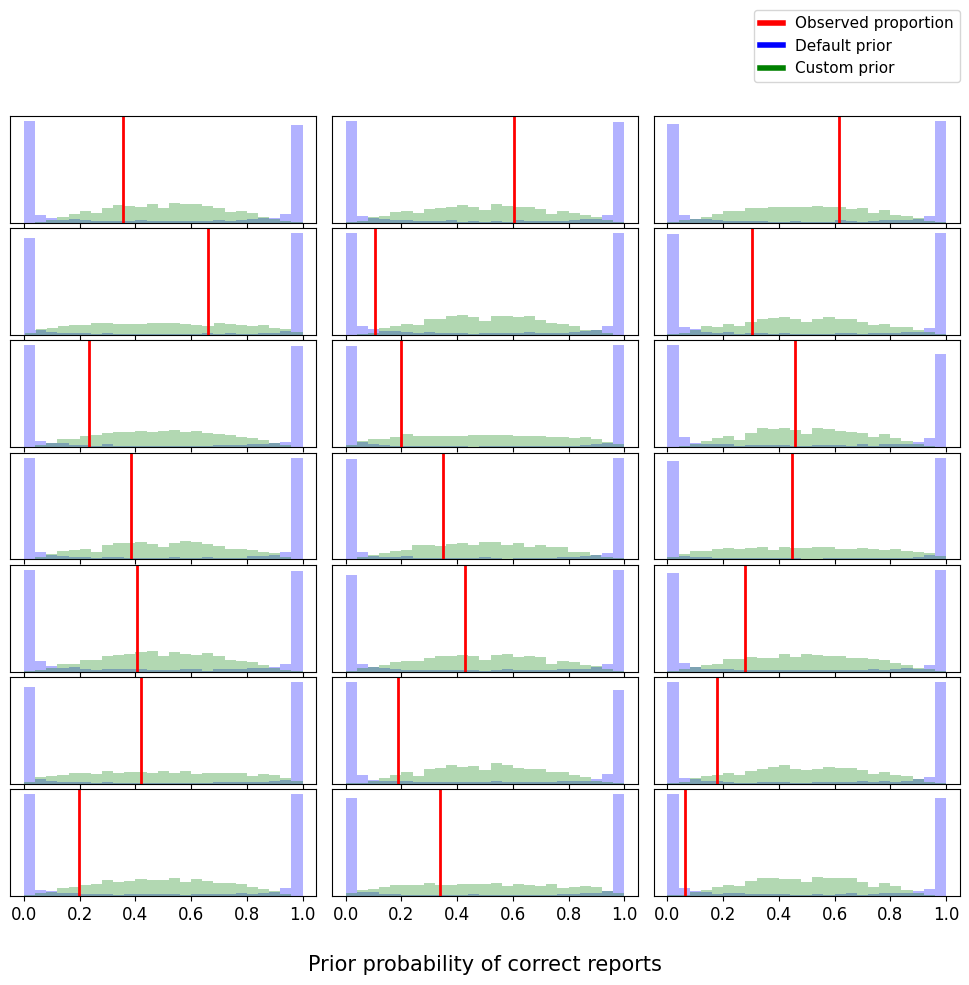

In [12]:
import arviz as az 
from plots import plot_prior_predictive
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data/Dataset_DistractorAbsent.csv', sep=';', decimal=',')
idata = az.from_netcdf('traces/DistractorAbsent_trace.nc')                                   
default_prior = az.extract_dataset(idata, group='default_prior_predictive')['p(correct, count)']
custom_prior = az.extract_dataset(idata, group='prior_predictive')['p(correct, count)']

axs = plot_prior_predictive(data, default_prior)
axs = plot_prior_predictive(data, custom_prior, axes=axs, draw_data=False, color='green')

### 3) Traceplots

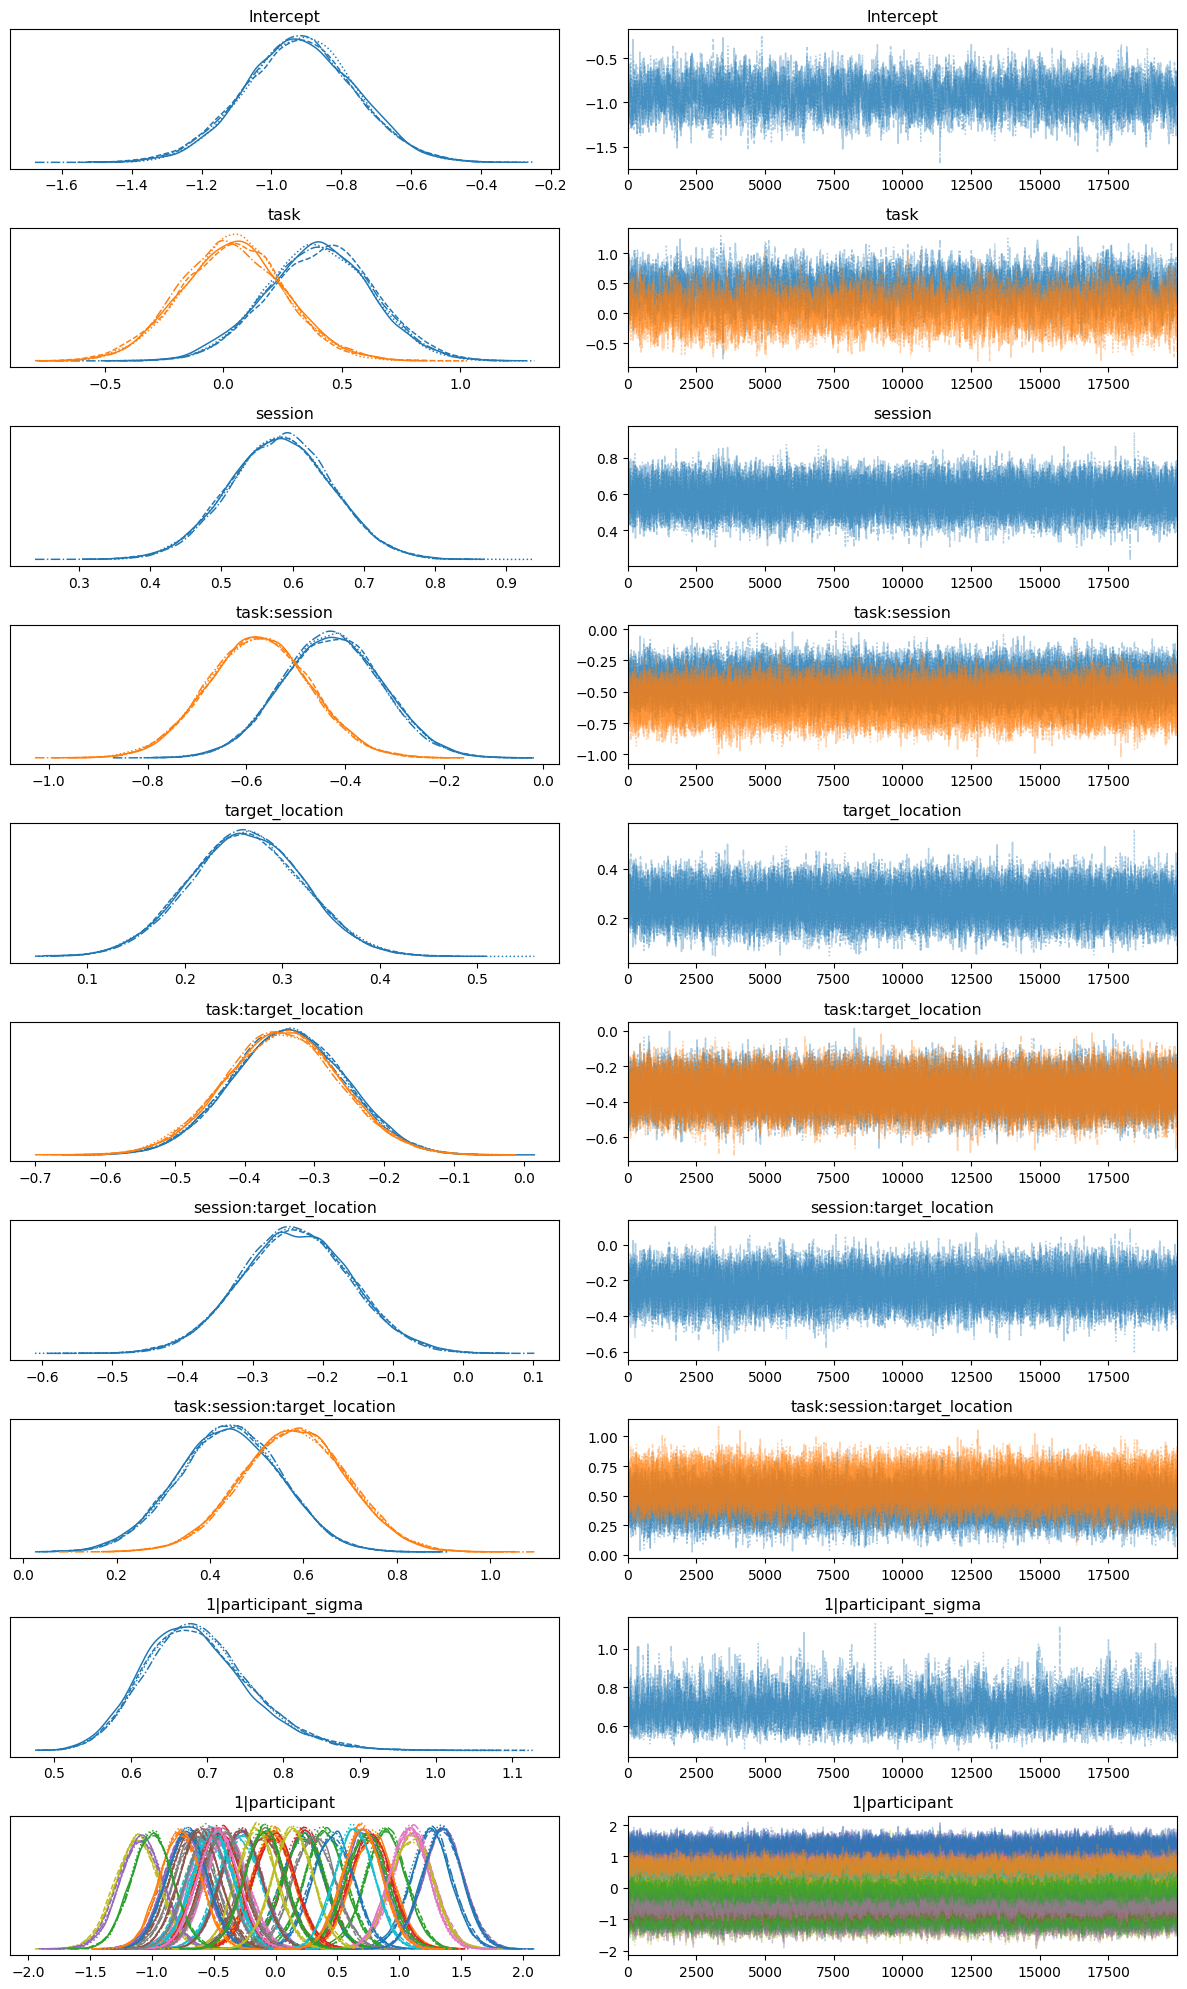

In [13]:
import arviz as az
from matplotlib.pylab import plt
import warnings
warnings.filterwarnings("ignore")

idata = az.from_netcdf('traces/DistractorAbsent_trace.nc') 
az.plot_trace(idata, compact=True)
plt.tight_layout()

### 4) Get summary

In [5]:
import arviz as az
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
az.rcParams['stats.hdi_prob'] = 0.95

pd.set_option('display.max_rows', None)
idata = az.from_netcdf('traces/DistractorAbsent_trace.nc') 
az.summary(idata)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.919,0.159,-1.235,-0.611,0.003,0.002,2708.0,5318.0,1.0
task[gray],0.402,0.225,-0.040,0.839,0.004,0.003,3380.0,6935.0,1.0
task[mixed],0.038,0.219,-0.385,0.478,0.004,0.003,3190.0,5632.0,1.0
session[2],0.582,0.072,0.438,0.721,0.001,0.001,9446.0,19652.0,1.0
"task:session[gray, 2]",-0.427,0.101,-0.628,-0.233,0.001,0.001,10899.0,21568.0,1.0
"task:session[mixed, 2]",-0.576,0.103,-0.779,-0.376,0.001,0.001,10802.0,23327.0,1.0
target_location[low],0.262,0.058,0.148,0.376,0.001,0.000,9653.0,20335.0,1.0
"task:target_location[gray, low]",-0.338,0.081,-0.496,-0.182,0.001,0.001,11062.0,22528.0,1.0
"task:target_location[mixed, low]",-0.346,0.082,-0.509,-0.187,0.001,0.001,11031.0,22158.0,1.0
"session:target_location[2, low]",-0.238,0.079,-0.390,-0.082,0.001,0.001,9061.0,18900.0,1.0


### 5) Compute predictions and comparisons

In [15]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import bambi as bmb
from bambi.interpret.helpers import data_grid, select_draws
import warnings
bmb.config["INTERPRET_VERBOSE"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get data
data = pd.read_csv('data/Dataset_DistractorAbsent.csv', sep=';', decimal=',')

# Define model
model = bmb.Model(
     'p(correct,count) ~ task*session*target_location + (1 | participant)',
    data, family='binomial', categorical=["session", "target_location", "task", "participant"])

# Get idata
idata = az.from_netcdf('traces/DistractorAbsent_trace.nc') 

# Create data_grid
tasks = ["color", "gray", "mixed"]
sessions = [1, 2]
participants_mixed = np.arange(1, 19)
participants_gray = np.arange(19, 36)
participants_color = np.arange(36, 54 )

variables = {"target_location": np.array(["high", "low"])}

data_dict = {}
idata_dict = {}

for task in tasks:
    for session in sessions:
        if task == "mixed":
            participants = participants_mixed
        elif task == "gray":
            participants = participants_gray
        else:
            participants = participants_color
            
        conditional = {"participant": participants, "session": np.array([session]), "task": np.array([task])}
        key = f"{task}_session{session}_data"
        data_dict[key] = data_grid(model, conditional, variables)
        idata_dict[key] = model.predict(idata, data=data_dict[key], inplace=False)
    

results_list = []
comparisons_list = []
hdi_high_list = []
hdi_low_list = []
hdi_diff_list = []

def calculate_stats(idata_dict, data_dict, session, task):
    key = f"{task}_session{session}_data"
    draws_high = select_draws(idata_dict[key], data_dict[key], {"target_location": "high"}, "p(correct, count)_mean")
    draws_low = select_draws(idata_dict[key], data_dict[key], {"target_location": "low"}, "p(correct, count)_mean")

    draws_high_mean = draws_high.mean("p(correct, count)_obs").values      
    hdi_high = az.hdi(draws_high.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_high_df = hdi_high.to_dataframe(dim_order=None)
    hdi_high_list.append(hdi_high_df)        
    results_list.append({"session": session, "target location": "high", "task": task, "estimate": np.mean(draws_high_mean)})
    
    draws_low_mean = draws_low.mean("p(correct, count)_obs").values
    results_list.append({"session": session, "target location": "low", "task": task, "estimate": np.mean(draws_low_mean)})   
    hdi_low = az.hdi(draws_low.mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_low_df = hdi_low.to_dataframe(dim_order=None)
    hdi_low_list.append(hdi_low_df)
    
    # Between conditions
    diff_low_high_mean = (draws_high - draws_low).mean("p(correct, count)_obs").values
    comparisons_list.append({"session": session, "target location": "Δ (low, high)", "task": task, "estimate": np.mean(diff_low_high_mean)})   
    hdi_diff = az.hdi((draws_high - draws_low).mean("p(correct, count)_obs"), input_core_dims=[["chain", "draw"]], hdi_prob=0.95)       
    hdi_diff_df = hdi_diff.to_dataframe(dim_order=None)
    hdi_diff_list.append(hdi_diff_df)

for session in sessions:
    for task in tasks:
        calculate_stats(idata_dict, data_dict, session, task)


estimates_df = pd.DataFrame(results_list)
estimates_df = estimates_df.sort_values(by=['session', 'target location']).reset_index(drop=True)

within_comparisons_df = pd.DataFrame(comparisons_list)
within_comparisons_df = within_comparisons_df.sort_values(by=['session']).reset_index(drop=True)

high_indices = estimates_df[estimates_df['target location'] == 'high'].index
low_indices = estimates_df[estimates_df['target location'] == 'low'].index
        
def extract_hdi_values(hdi_df):
    lower_value = hdi_df.loc['lower', 'p(correct, count)_mean']
    higher_value = hdi_df.loc['higher', 'p(correct, count)_mean']
    return lower_value, higher_value

for high_index, hdi_df in zip(high_indices, hdi_high_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    estimates_df.at[high_index, 'lower_2.5%'] = lower_col
    estimates_df.at[high_index, 'upper_97.5%'] = higher_col

for low_index, hdi_df in zip(low_indices, hdi_low_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    estimates_df.at[low_index, 'lower_2.5%'] = lower_col
    estimates_df.at[low_index, 'upper_97.5%'] = higher_col
    
for i, hdi_df in enumerate(hdi_diff_list):
    lower_col, higher_col = extract_hdi_values(hdi_df)
    within_comparisons_df.at[i, 'lower_2.5%'] = lower_col
    within_comparisons_df.at[i, 'upper_97.5%'] = higher_col
    
estimates_df[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
estimates_df = estimates_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})

within_comparisons_df[['estimate', 'lower_2.5%', 'upper_97.5%']] *= 100
within_comparisons_df = within_comparisons_df.round({'estimate': 2, 'lower_2.5%': 2, 'upper_97.5%': 2})

display(estimates_df)
display(within_comparisons_df)

,session,target location,task,estimate,lower_2.5%,upper_97.5%
0,1,high,color,29.51,27.59,31.44
1,1,high,gray,38.89,36.68,41.13
2,1,high,mixed,30.38,28.39,32.48
3,1,low,color,34.54,33.59,35.47
4,1,low,gray,37.25,36.22,38.23
5,1,low,mixed,28.78,27.86,29.68
6,2,high,color,41.17,39.03,43.27
7,2,high,gray,42.31,40.00,44.54
8,2,high,mixed,30.51,28.46,32.58
9,2,low,color,41.68,40.73,42.67


,session,target location,task,estimate,lower_2.5%,upper_97.5%
0,1,"Δ (low, high)",color,-5.03,-7.14,-2.88
1,1,"Δ (low, high)",gray,1.64,-0.77,4.10
2,1,"Δ (low, high)",mixed,1.61,-0.63,3.83
3,2,"Δ (low, high)",color,-0.51,-2.86,1.80
4,2,"Δ (low, high)",gray,-2.83,-5.37,-0.39
5,2,"Δ (low, high)",mixed,-5.20,-7.45,-2.91


### 6) Plot predictions

Please note that the following cell must be run together with the previous cell.

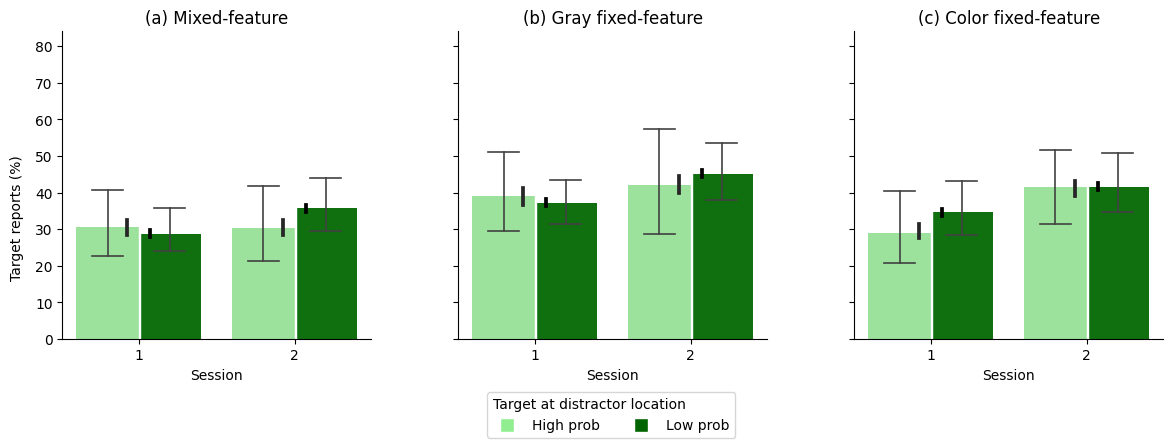

In [16]:
import warnings
warnings.filterwarnings("ignore")
import arviz as az
import bambi as bmb
import pandas as pd
import seaborn as sns
import pymc as pm
import numpy as np
from pandas.api.types import CategoricalDtype
from matplotlib.pylab import plt
from matplotlib.lines import Line2D
from matplotlib import cycler
from matplotlib.patches import Rectangle
import scipy
from scikits import bootstrap

default_cycler = cycler(color=['black'])
plt.rc('axes', prop_cycle=default_cycler)


data = pd.read_csv('data/Dataset_DistractorAbsent.csv', sep=';', decimal=',') 
data['report frequency target (%)'] = (data['correct'] / data['count'])*100

idata = az.from_netcdf('traces/DistractorAbsent_trace.nc')

model = bmb.Model(
    'p(correct,count) ~ task*session*target_location + (1 | participant)',
    data, family='binomial', categorical=['condition', 'session', 'task', 'participant']
)

palette ={"high": "lightgreen", "low": "green"}
width = 0.4


# Plot observed data 
g = sns.FacetGrid(data, col='task', height=4, col_order = ["color", "gray", "mixed"], )
target_plot = g.map(sns.barplot, 'session', 'report frequency target (%)', 'target_location', palette=palette, errorbar=lambda y: bootstrap.ci(y, statfunction=lambda x: np.mean(x, axis=0), method='bca'), capsize=0.2, errwidth=1.2)

# Plot predictions
def get_hdi(x):
    row = task_data[np.isclose(task_data['estimate'], x.values[0])]
    return (row['lower_2.5%'].values[0], row['upper_97.5%'].values[0])

for ax, task in zip(g.axes.flat, ["color", "gray", "mixed"]):
    task_data = estimates_df[estimates_df['task'] == task]
    task_data = pd.concat([task_data, task_data]).reset_index(drop=True)
    sns.pointplot(x='session', y='estimate', hue='target location', color='black', ax=ax, data=task_data, errorbar=lambda x: get_hdi(x), join=False, dodge=.15, scale=0.1)
    ax.legend_.remove()
       
# change/remove labels
plt.figure(1).axes[0].get_yaxis().get_label().set(text='')
plt.figure(1).axes[0].set_title("(c) Color fixed-feature")
plt.figure(1).axes[0].tick_params(left = True, labelleft = False)
plt.figure(1).axes[1].set_title("(b) Gray fixed-feature")
plt.figure(1).axes[2].set_title("(a) Mixed-feature")
plt.figure(1).axes[2].tick_params(left = True, labelleft = True)

# change order of subplots
plt.figure(1).axes[1].set(position=[0.37, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[0].set(position=[0.7, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[2].set(position=[0.04, 0.1457, 0.257, 0.7685])
plt.figure(1).axes[2].text(-0.17, 0.2, 'Target reports (%)', transform=plt.figure(1).axes[2].transAxes, rotation=90.) 

# Add white line between barplots
for i in [0, 1, 2]:
    ax = plt.figure(1).axes[i]
    ax.get_xaxis().get_label().set(text='Session')
    for x in [0, 1]:
        ax.add_patch(Rectangle((x, 0), 0.01, 80, color='white', zorder=2))
        
# Create a custom legend
legend_labels = ['High prob', 'Low prob']
custom_legend = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='lightgreen', markersize=10, label=legend_labels[0]),
                 plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='darkgreen', markersize=10, label=legend_labels[1])]
                
plt.legend(handles=custom_legend, loc='upper center', bbox_to_anchor=(1.78, -0.15), title='Target at distractor location', ncol=2, frameon=True, alignment="left")
_=plt.plot()